# Synthetic OTF Validation

This notebook generates synthetic particle images with a known ground-truth OTF (spatially varying Gaussian width) to validate the OTF calibration accuracy of OpenLPT.

**Workflow:**
1. Load tracks from `data.mat`
2. Load camera parameters from `camFile`
3. Generate a synthetic OTF with spatial gradient
4. Render synthetic images for 4 cameras
5. Generate OpenLPT config files
6. Run OpenLPT and compare recovered OTF to ground truth

In [4]:
import numpy as np
import scipy.io as sio
import cv2
import os

# === Configuration ===
# Input paths
DATA_MAT_PATH = r"D:\0.Code\OpenLPTGUI\OpenLPT\test\inputs\test_STB_Bubble\data.mat"
CAM_FILE_DIR = r"D:\0.Code\OpenLPTGUI\OpenLPT\test\inputs\test_STB_Bubble\camFile"

# Output paths
OUTPUT_ROOT = r"D:\0.Code\Test\OTF_test"
IMG_DIR = os.path.join(OUTPUT_ROOT, "imgFile")

# Image parameters (match camera calibration)
IMG_SIZE = (1024, 1024)  # (height, width)
N_CAMERAS = 4

# View Volume (mm)
VIEW_VOLUME = (-20, 20, -20, 20, -20, 20)  # xmin,xmax,ymin,ymax,zmin,zmax

print(f"Output directory: {OUTPUT_ROOT}")

Output directory: D:\0.Code\Test\OTF_test


## 1. Load Tracks from data.mat

In [9]:
# Load .mat file
mat_data = sio.loadmat(DATA_MAT_PATH)
print("Keys in mat file:", mat_data.keys())

# Extract tracks: [X, Y, Z, frame_no, track_ID]
tracks = mat_data['tracks']
print(f"Tracks shape: {tracks.shape}")
print(f"First 5 rows:\n{tracks[:5, :]}")

# Get frame range
frame_ids = np.unique(tracks[:, 3].astype(int))
print(f"Frame range: {frame_ids.min()} - {frame_ids.max()} ({len(frame_ids)} frames)")

Keys in mat file: dict_keys(['__header__', '__version__', '__globals__', 'b_ref', 'camParaCalib', 'dir', 'num_bubble', 'r_mm', 'tracks'])
Tracks shape: (250000, 5)
First 5 rows:
[[-14.05960159  -2.87374236 -18.08842509   1.           1.        ]
 [  3.65857168 -19.39848787  -1.6787719    1.           2.        ]
 [  1.16787335  -8.0599179  -11.24099804   1.           3.        ]
 [ 14.43463852 -12.07557811 -19.35356619   1.           4.        ]
 [ 12.42699396 -16.55398481 -12.54355081   1.           5.        ]]
Frame range: 1 - 250 (250 frames)


## 2. Load Camera Parameters

In [10]:
def load_camera_params(filepath):
    """Parse camera parameter file in OpenLPT format."""
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    cam = {}
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if line.startswith('# Image Size'):
            i += 1
            h, w = map(int, lines[i].strip().split(','))
            cam['size'] = (h, w)
        elif line.startswith('# Camera Matrix'):
            i += 1
            K = []
            for _ in range(3):
                K.append([float(x) for x in lines[i].strip().split(',')])
                i += 1
            cam['K'] = np.array(K)
            i -= 1  # Adjust for outer loop increment
        elif line.startswith('# Distortion'):
            i += 1
            cam['dist'] = np.array([float(x) for x in lines[i].strip().split(',')])
        elif line.startswith('# Rotation Matrix'):
            i += 1
            R = []
            for _ in range(3):
                R.append([float(x) for x in lines[i].strip().split(',')])
                i += 1
            cam['R'] = np.array(R)
            i -= 1
        elif line.startswith('# Translation Vector'):
            i += 1
            cam['t'] = np.array([float(x) for x in lines[i].strip().split(',')])
        i += 1
    return cam

# Load all cameras
cameras = []
for cam_id in range(1, N_CAMERAS + 1):
    cam_path = os.path.join(CAM_FILE_DIR, f"cam{cam_id}.txt")
    cam = load_camera_params(cam_path)
    cameras.append(cam)
    print(f"Loaded camera {cam_id}: fx={cam['K'][0,0]:.2f}, size={cam['size']}")

Loaded camera 1: fx=10148.27, size=(1024, 1024)
Loaded camera 2: fx=10569.84, size=(1024, 1024)
Loaded camera 3: fx=10457.44, size=(1024, 1024)
Loaded camera 4: fx=10343.00, size=(1024, 1024)


## 3. Define Ground-Truth OTF (Spatially Varying)

In [11]:
import numpy as np

def ground_truth_otf(x, y, z):
    """
    Define a spatially varying OTF with all 4 parameters.
    Applies b <= c normalization (same as C++ code).
    
    Spatial gradients:
    - a (intensity): 150 → 200, varies with Z
    - b (major axis): 1.0 → 2.0, varies with Z
    - c (minor axis): 2.0 → 1.0, varies with Z (inverse)
    - alpha (rotation): -5° → +5°, varies with X
    
    After normalization (b <= c):
    - At z=-20: b=1.0, c=2.0, alpha unchanged
    - At z=0:   b=1.5, c=1.5, alpha unchanged
    - At z=+20: b=1.0, c=2.0, alpha +90° (swapped!)
    """
    xmin, xmax = VIEW_VOLUME[0], VIEW_VOLUME[1]
    zmin, zmax = VIEW_VOLUME[4], VIEW_VOLUME[5]
    
    # Normalize positions to [0, 1]
    x_norm = (x - xmin) / (xmax - xmin)
    z_norm = (z - zmin) / (zmax - zmin)
    
    # a: intensity varies with Z (150 → 200)
    a = 150 + 50 * z_norm
    
    # Raw b and c before normalization
    b_raw = 1 + 1.0 * z_norm  # 1.0 → 2.0
    c_raw = 2 - 1.0 * z_norm  # 2.0 → 1.0
    
    # alpha: rotation angle varies with X (-5° → +5°)
    alpha_deg = -5 + 10 * x_norm
    alpha_raw = np.radians(alpha_deg)
    
    # === Normalization: Enforce b <= c ===
    if b_raw > c_raw:
        b = c_raw
        c = b_raw
        alpha = alpha_raw + np.pi / 2  # Add 90 degrees
    else:
        b = b_raw
        c = c_raw
        alpha = alpha_raw
    
    # Normalize alpha to [-pi/2, pi/2]
    while alpha > np.pi / 2:
        alpha -= np.pi
    while alpha < -np.pi / 2:
        alpha += np.pi
    
    return a, b, c, alpha

# Test - 验证标准化效果
print("OTF at z=-20:", ground_truth_otf(0, 0, -20))
print("  → b=1.0 < c=2.0, no swap")
print("OTF at z=0:  ", ground_truth_otf(0, 0, 0))
print("  → b=1.5 = c=1.5, no swap")
print("OTF at z=+20:", ground_truth_otf(0, 0, 20))
print("  → raw b=2.0 > c=1.0, SWAPPED to b=1.0, c=2.0, alpha +90°")

OTF at z=-20: (150.0, 1.0, 2.0, np.float64(0.0))
  → b=1.0 < c=2.0, no swap
OTF at z=0:   (175.0, 1.5, 1.5, np.float64(0.0))
  → b=1.5 = c=1.5, no swap
OTF at z=+20: (200.0, 1.0, 2.0, np.float64(1.5707963267948966))
  → raw b=2.0 > c=1.0, SWAPPED to b=1.0, c=2.0, alpha +90°


## 4. Project 3D Points to 2D and Render Images

In [12]:
def project_point(cam, X, Y, Z):
    """
    Project a 3D world point to 2D image coordinates.
    Returns (u, v) pixel coordinates.
    """
    # World to Camera
    P_world = np.array([X, Y, Z])
    P_cam = cam['R'] @ P_world + cam['t']
    
    # Camera to Image (Pinhole model)
    if P_cam[2] <= 0:
        return None  # Behind camera
    
    x = P_cam[0] / P_cam[2]
    y = P_cam[1] / P_cam[2]
    
    # Apply camera matrix
    K = cam['K']
    u = K[0, 0] * x + K[0, 2]
    v = K[1, 1] * y + K[1, 2]
    
    return u, v

def render_gaussian(img, u, v, a, b, c, alpha):
    """
    Render an elliptical Gaussian particle at (u, v).
    
    I(x,y) = a * exp(-b*dx² - c*dy²)
    where:
      dx =  (x-u)*cos(α) + (y-v)*sin(α)
      dy = -(x-u)*sin(α) + (y-v)*cos(α)
    """
    h, w = img.shape
    
    # Determine ROI size based on max sigma
    sigma_max = max(1.0 / np.sqrt(2*b), 1.0 / np.sqrt(2*c)) if min(b, c) > 0 else 5
    radius = int(np.ceil(3 * sigma_max))
    u_int, v_int = int(round(u)), int(round(v))
    
    if u_int < radius or u_int >= w - radius:
        return
    if v_int < radius or v_int >= h - radius:
        return
    
    # Create coordinate grid
    y_range = np.arange(v_int - radius, v_int + radius + 1)
    x_range = np.arange(u_int - radius, u_int + radius + 1)
    yy, xx = np.meshgrid(y_range, x_range, indexing='ij')
    
    # Rotated coordinates
    cos_a = np.cos(alpha)
    sin_a = np.sin(alpha)
    dx =  (xx - u) * cos_a + (yy - v) * sin_a
    dy = -(xx - u) * sin_a + (yy - v) * cos_a
    
    # Elliptical Gaussian
    gauss = a * np.exp(-b * dx**2 - c * dy**2)
    
    # Add to image
    y_start, y_end = v_int - radius, v_int + radius + 1
    x_start, x_end = u_int - radius, u_int + radius + 1
    
    # 取最大值而非累加
    img[y_start:y_end, x_start:x_end] = np.maximum(
        img[y_start:y_end, x_start:x_end],
        gauss.astype(np.float32)
    )

# Test projection
test_pt = project_point(cameras[0], 0, 0, 0)
print(f"Test projection (0,0,0) -> {test_pt}")

Test projection (0,0,0) -> (np.float64(516.1812019410562), np.float64(514.9824151297369))


In [13]:
# Create output directories
os.makedirs(OUTPUT_ROOT, exist_ok=True)
for cam_id in range(1, N_CAMERAS + 1):
    os.makedirs(os.path.join(IMG_DIR, f"cam{cam_id}"), exist_ok=True)

# Render images for each frame
frame_ids = np.unique(tracks[:, 3].astype(int))
n_frames = len(frame_ids)

print(f"Rendering {n_frames} frames for {N_CAMERAS} cameras...")
for i, frame_id in enumerate(frame_ids):
    if i % 20 == 0:
        print(f"  Progress: {i+1}/{n_frames} frames...")
    
    # Get particles in this frame
    mask = tracks[:, 3].astype(int) == frame_id
    particles = tracks[mask, :3]  # X, Y, Z
    
    # Render for each camera
    for cam_id, cam in enumerate(cameras):
        img = np.zeros(IMG_SIZE, dtype=np.float32)
        
        for pt in particles:
            X, Y, Z = pt
            
            # Get OTF at this location (now returns 4 params)
            a, b, c, alpha = ground_truth_otf(X, Y, Z)
            
            # Project to 2D
            proj = project_point(cam, X, Y, Z)
            if proj is None:
                continue
            u, v = proj
            
            # Render elliptical Gaussian with full OTF
            render_gaussian(img, u, v, a, b, c, alpha)
        
        # Clip and convert to 8-bit
        img = np.clip(img, 0, 255).astype(np.uint8)
        
        # Save image
        filename = f"img{frame_id+1:05d}.tif"
        filepath = os.path.join(IMG_DIR, f"cam{cam_id+1}", filename)
        cv2.imwrite(filepath, img)

print(f"Done! Images saved to {IMG_DIR}")

Rendering 250 frames for 4 cameras...
  Progress: 1/250 frames...
  Progress: 21/250 frames...
  Progress: 41/250 frames...
  Progress: 61/250 frames...
  Progress: 81/250 frames...
  Progress: 101/250 frames...
  Progress: 121/250 frames...
  Progress: 141/250 frames...
  Progress: 161/250 frames...
  Progress: 181/250 frames...
  Progress: 201/250 frames...
  Progress: 221/250 frames...
  Progress: 241/250 frames...
Done! Images saved to D:\0.Code\Test\OTF_test\imgFile


## 5. Generate OpenLPT Config Files

In [10]:
# Copy camera files to output directory
import shutil

cam_out_dir = os.path.join(OUTPUT_ROOT, "camFile")
os.makedirs(cam_out_dir, exist_ok=True)

for cam_id in range(1, N_CAMERAS + 1):
    src = os.path.join(CAM_FILE_DIR, f"cam{cam_id}.txt")
    dst = os.path.join(cam_out_dir, f"cam{cam_id}.txt")
    shutil.copy(src, dst)
print(f"Copied camera files to {cam_out_dir}")

Copied camera files to D:\0.Code\Test\OTF_test\camFile


In [12]:
# Generate image name files
for cam_id in range(1, N_CAMERAS + 1):
    filepath = os.path.join(IMG_DIR, f"cam{cam_id}ImageNames.txt")
    with open(filepath, 'w') as f:
        for frame_id in frame_ids:
            # 使用绝对路径
            img_path = os.path.join(IMG_DIR, f"cam{cam_id}", f"img{frame_id+1:05d}.tif")
            abs_path = os.path.abspath(img_path).replace('\\', '/')
            f.write(abs_path + '\n')
    print(f"Generated {filepath}")

Generated D:\0.Code\Test\OTF_test\imgFile\cam1ImageNames.txt
Generated D:\0.Code\Test\OTF_test\imgFile\cam2ImageNames.txt
Generated D:\0.Code\Test\OTF_test\imgFile\cam3ImageNames.txt
Generated D:\0.Code\Test\OTF_test\imgFile\cam4ImageNames.txt


In [13]:
# Generate tracerConfig.txt
tracer_config = os.path.join(OUTPUT_ROOT, "tracerConfig.txt")
with open(tracer_config, 'w') as f:
    f.write("""############################
######### Tracking #########
############################
######### Initial Phase ############## 
10 # Search radius for connecting tracks to objects
4 # Number of frames for initial phase
######### Convergence Phase ############# 
30 # Avg Interparticle spacing. (vox) to identify neighbour tracks 

#########################
######### Shake #########
#########################
0.25 # shake width

#################################
######### Predict Field #########
#################################
51 # xgrid 
51 # ygrid
51 # zgrid
25 # searchRadius [voxel]

#######################
######### IPR #########
#######################
2   # No. of IPR loop
4   # No. of Shake loop
0.1 # ghost threshold
0.8   # 2D tolerance [px]
1.0  # 3D tolerance [voxel]

1 # number of reduced camera
2 # no. of ipr loops for each reduced camera combination


###############################
######### Object Info #########
###############################
30 # 2D particle finder threshold
2 # Particle radius [px], for calculating residue image and shaking
""")
print(f"Generated {tracer_config}")

Generated D:\0.Code\Test\OTF_test\tracerConfig.txt


In [15]:
# Generate main config.txt
config_path = os.path.join(OUTPUT_ROOT, "config.txt")

frame_start, frame_end = int(frame_ids.min()), int(frame_ids.max())

# 预先计算所有绝对路径
cam_out_dir_abs = os.path.abspath(os.path.join(OUTPUT_ROOT, "camFile")).replace('\\', '/')
img_dir_abs = os.path.abspath(IMG_DIR).replace('\\', '/')
results_dir_abs = os.path.abspath(os.path.join(OUTPUT_ROOT, "Results")).replace('\\', '/')
tracer_config_abs = os.path.abspath(os.path.join(OUTPUT_ROOT, "tracerConfig.txt")).replace('\\', '/')

with open(config_path, 'w') as f:
    f.write(f"""# Frame Range: [startID,endID]
{frame_start},{frame_end}
# Frame Rate: [Hz]
1
# Number of Threads: (0: use as many as possible)
0
# Number of Cameras: 
{N_CAMERAS}
# Camera File Path, Max Intensity
""")
    for cam_id in range(1, N_CAMERAS + 1):
        cam_abs = f"{cam_out_dir_abs}/cam{cam_id}.txt"
        f.write(f"{cam_abs},255\n")
    
    f.write("# Image File Path\n")
    for cam_id in range(1, N_CAMERAS + 1):
        img_names_abs = f"{img_dir_abs}/cam{cam_id}ImageNames.txt"
        f.write(f"{img_names_abs}\n")
    
    xmin, xmax, ymin, ymax, zmin, zmax = VIEW_VOLUME
    voxel_size = (xmax - xmin) / 1000.0
    
    f.write(f"""# View Volume: (xmin,xmax,ymin,ymax,zmin,zmax)
{xmin},{xmax},{ymin},{ymax},{zmin},{zmax}
# Voxel to MM: e.g. use 1000^3 voxel, (xmax-xmin)/1000
{voxel_size}
# Output Folder Path: 
{results_dir_abs}/
# Object Types: 
Tracer
# STB Config Files:
{tracer_config_abs}
# Flag to load previous track files, previous frameID
0,-1
# Path to active long track files
{results_dir_abs}/Tracer_0/LongTrackActive_20.csv
# Path to active short track files
{results_dir_abs}/Tracer_0/ShortTrackActive_20.csv
""")

print(f"Generated {config_path}")

Generated D:\0.Code\Test\OTF_test\config.txt


In [ ]:
# Create Results directory
os.makedirs(os.path.join(OUTPUT_ROOT, "Results"), exist_ok=True)
print(f"\nSynthetic data generation complete!")
print(f"Output: {OUTPUT_ROOT}")
print(f"\nNext steps:")
print(f"1. Open OpenLPT GUI")
print(f"2. Load the project from: {config_path}")
print(f"3. Run STB processing")
print(f"4. Enable VSC to calibrate OTF")
print(f"5. Compare recovered OTF to ground truth (b varies from 1.0 to 3.0 across Z)")

## 6. Save Ground Truth OTF for Comparison

In [14]:
# Save ground truth OTF in the same format as OpenLPT outputs
import math

# Match OpenLPT OTF grid (3x3x3 default)
nx, ny, nz = 5, 5, 5
n_grid = nx * ny * nz

xmin, xmax, ymin, ymax, zmin, zmax = VIEW_VOLUME

# Generate ground truth OTF values at each grid point
gt_a = np.zeros((N_CAMERAS, n_grid))
gt_b = np.zeros((N_CAMERAS, n_grid))
gt_c = np.zeros((N_CAMERAS, n_grid))
gt_alpha = np.zeros((N_CAMERAS, n_grid))

idx = 0
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            x = xmin + i * (xmax - xmin) / (nx - 1) if nx > 1 else 0
            y = ymin + j * (ymax - ymin) / (ny - 1) if ny > 1 else 0
            z = zmin + k * (zmax - zmin) / (nz - 1) if nz > 1 else 0
            
            a, b, c, alpha = ground_truth_otf(x, y, z)
            
            # Same OTF for all cameras in this synthetic test
            for cam_id in range(N_CAMERAS):
                gt_a[cam_id, idx] = a
                gt_b[cam_id, idx] = b
                gt_c[cam_id, idx] = c
                gt_alpha[cam_id, idx] = alpha
            
            idx += 1

# Save to file
gt_otf_path = os.path.join(OUTPUT_ROOT, "OTF_ground_truth.txt")
with open(gt_otf_path, 'w') as f:
    f.write(f"# Size: n_cam, nx, ny, nz, n_grid\n")
    f.write(f"{N_CAMERAS},{nx},{ny},{nz},{n_grid}\n")
    f.write(f"# Boundary: xmin, xmax, ymin, ymax, zmin, zmax\n")
    f.write(f"{xmin},{xmax},{ymin},{ymax},{zmin},{zmax}\n")
    f.write(f"# a\n")
    for cam_id in range(N_CAMERAS):
        f.write(",".join(f"{v:.6f}" for v in gt_a[cam_id]) + "\n")
    f.write(f"# b\n")
    for cam_id in range(N_CAMERAS):
        f.write(",".join(f"{v:.6f}" for v in gt_b[cam_id]) + "\n")
    f.write(f"# c\n")
    for cam_id in range(N_CAMERAS):
        f.write(",".join(f"{v:.6f}" for v in gt_c[cam_id]) + "\n")
    f.write(f"# alpha\n")
    for cam_id in range(N_CAMERAS):
        f.write(",".join(f"{v:.6f}" for v in gt_alpha[cam_id]) + "\n")

print(f"Ground truth OTF saved to: {gt_otf_path}")
print(f"\nExpected parameter ranges across the volume:")
print(f"  a (intensity): 150 → 200")
print(f"  b (major axis): 1.0 → 2.0")
print(f"  c (minor axis): 1.0 → 2.0")
print(f"  alpha (rotation): -5° → +5° ({math.radians(-5):.4f} → {math.radians(5):.4f} rad)")

Ground truth OTF saved to: D:\0.Code\Test\OTF_test\OTF_ground_truth.txt

Expected parameter ranges across the volume:
  a (intensity): 150 → 200
  b (major axis): 1.0 → 2.0
  c (minor axis): 1.0 → 2.0
  alpha (rotation): -5° → +5° (-0.0873 → 0.0873 rad)


In [1]:
import pyopenlpt as lpt

config_file = r"D:\0.Code\Test\OTF_test\config.txt"
with lpt.PythonStreamRedirector():
    lpt.run(config_file)

Estimating OTF...
Camera 0 (a,b,c,alpha) = 184.86,1.59,1.59,0.00

Camera 1 (a,b,c,alpha) = 185.81,1.59,1.59,0.00

Camera 2 (a,b,c,alpha) = 186.74,1.59,1.59,0.00

Camera 3 (a,b,c,alpha) = 186.49,1.60,1.58,0.00

**************
OpenLPT start!
**************

Initial phase at frame 1
START IPR...
Full cameras
Combination 0 cams=[0, 1, 2, 3]
		2D detections per active camera: 947  917  930  947   (0.00 s)
		Matched 820 objects. ( 2D tol: 1.00, t:0.01 s)	After shaking: 820 objects remain. (0.05 s)
	LOOP=0: TOTAL OBJECTS = 820
		2D detections per active camera: 141  111  126  137   (0.00 s)
		Matched 6 objects. ( 2D tol: 1.50, t:0.00 s)	After shaking: 6 objects remain. (0.02 s)
	LOOP=1: TOTAL OBJECTS = 826
Reduced cameras
Combination 0 cams=[0, 1, 2]
		2D detections per active camera: 106  134  131   (0.00 s)
		Matched 31 objects. ( 2D tol: 1.00, t:0.00 s)	After shaking: 31 objects remain. (0.02 s)
	LOOP=0: TOTAL OBJECTS = 857
		2D detections per active camera: 75  104  100   (0.00 s)
		Match

In [2]:
## 7. Compare Recovered OTF with Ground Truth

## 7. Compare Recovered OTF with Ground Truth

import numpy as np
import matplotlib.pyplot as plt

# Load recovered OTF
recovered_otf_path = r"D:\0.Code\Test\OTF_test\Results\OTF.txt"
gt_otf_path = r"D:\0.Code\Test\OTF_test\OTF_ground_truth.txt"

# ... 后续代码不变 ...

def load_otf(filepath):
    """Parse OTF.txt file."""
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    # Parse header
    header_size = lines[1].strip().split(',')
    n_cam = int(header_size[0])
    nx = int(header_size[1])
    ny = int(header_size[2])
    nz = int(header_size[3])
    n_grid = int(header_size[4])
    
    header_bound = lines[3].strip().split(',')
    bounds = [float(x) for x in header_bound]
    
    def parse_matrix(start_line, rows, cols):
        mat = np.zeros((rows, cols))
        for r in range(rows):
            vals = [float(x) for x in lines[start_line + r].strip().split(',') if x]
            mat[r, :] = vals[:cols]
        return mat
    
    curr = 5  # Start of 'a' data
    a = parse_matrix(curr, n_cam, n_grid)
    curr += n_cam + 1  # Skip data + comment
    b = parse_matrix(curr, n_cam, n_grid)
    curr += n_cam + 1
    c = parse_matrix(curr, n_cam, n_grid)
    curr += n_cam + 1
    alpha = parse_matrix(curr, n_cam, n_grid)
    
    return {
        'n_cam': n_cam, 'nx': nx, 'ny': ny, 'nz': nz, 'n_grid': n_grid,
        'bounds': bounds, 'a': a, 'b': b, 'c': c, 'alpha': alpha
    }

# Load both OTF files
recovered = load_otf(recovered_otf_path)
ground_truth = load_otf(gt_otf_path)

print("=== OTF Comparison ===")
print(f"Grid size: {recovered['nx']}x{recovered['ny']}x{recovered['nz']}")
print(f"Number of cameras: {recovered['n_cam']}")
print()

# Compare for each camera
for cam_id in range(recovered['n_cam']):
    print(f"--- Camera {cam_id + 1} ---")
    
    for param_name in ['a', 'b', 'c', 'alpha']:
        gt_vals = ground_truth[param_name][cam_id]
        rec_vals = recovered[param_name][cam_id]
        
        # Calculate errors
        abs_error = np.abs(rec_vals - gt_vals)
        rel_error = abs_error / (np.abs(gt_vals) + 1e-9) * 100
        
        print(f"  {param_name}:")
        print(f"    Ground Truth: min={gt_vals.min():.4f}, max={gt_vals.max():.4f}, mean={gt_vals.mean():.4f}")
        print(f"    Recovered:    min={rec_vals.min():.4f}, max={rec_vals.max():.4f}, mean={rec_vals.mean():.4f}")
        print(f"    Abs Error:    mean={abs_error.mean():.4f}, max={abs_error.max():.4f}")
        print(f"    Rel Error:    mean={rel_error.mean():.1f}%, max={rel_error.max():.1f}%")
    print()

=== OTF Comparison ===
Grid size: 5x5x5
Number of cameras: 4

--- Camera 1 ---
  a:
    Ground Truth: min=150.0000, max=200.0000, mean=175.0000
    Recovered:    min=140.4902, max=200.5442, mean=169.5947
    Abs Error:    mean=5.8529, max=33.3621
    Rel Error:    mean=3.2%, max=16.7%
  b:
    Ground Truth: min=1.0000, max=1.5000, mean=1.2000
    Recovered:    min=1.0842, max=1.5459, mean=1.3766
    Abs Error:    mean=0.1796, max=0.4517
    Rel Error:    mean=16.5%, max=45.2%
  c:
    Ground Truth: min=1.5000, max=2.0000, mean=1.8000
    Recovered:    min=1.1513, max=1.5459, mean=1.3856
    Abs Error:    mean=0.4170, max=0.8487
    Rel Error:    mean=21.8%, max=42.4%
  alpha:
    Ground Truth: min=-1.5272, max=1.5708, mean=0.1257
    Recovered:    min=-0.0211, max=0.0129, mean=-0.0002
    Abs Error:    mean=0.6384, max=1.5708
    Rel Error:    mean=384885.7%, max=13519717.7%

--- Camera 2 ---
  a:
    Ground Truth: min=150.0000, max=200.0000, mean=175.0000
    Recovered:    min=134.338

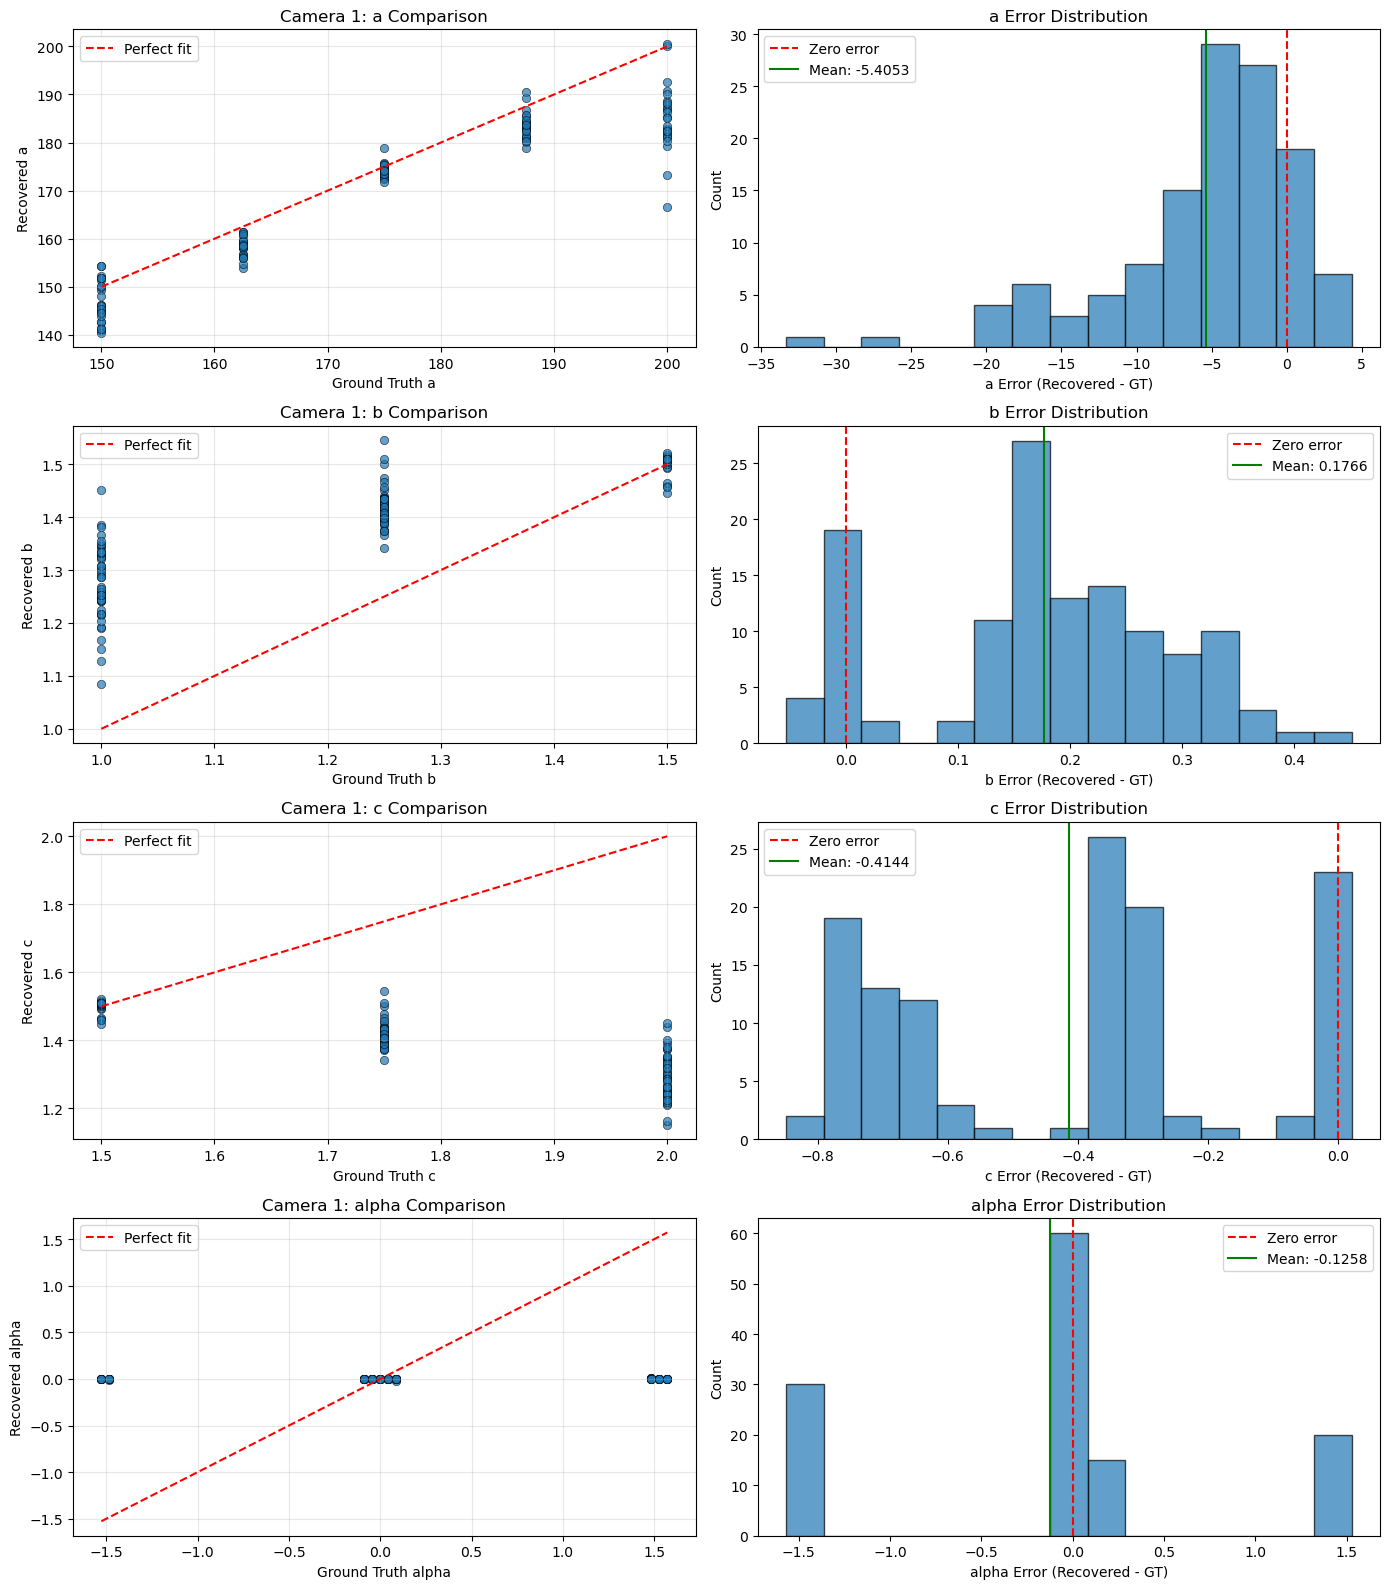

In [3]:
## 8. Visualize Comparison

fig, axes = plt.subplots(4, 2, figsize=(14, 16))
param_names = ['a', 'b', 'c', 'alpha']

cam_id = 0  # 可视化第一个相机

for i, param_name in enumerate(param_names):
    gt_vals = ground_truth[param_name][cam_id]
    rec_vals = recovered[param_name][cam_id]
    
    ax1 = axes[i, 0]
    ax2 = axes[i, 1]
    
    # Scatter plot: Ground Truth vs Recovered
    ax1.scatter(gt_vals, rec_vals, alpha=0.7, edgecolors='k', linewidth=0.5)
    ax1.plot([gt_vals.min(), gt_vals.max()], [gt_vals.min(), gt_vals.max()], 'r--', label='Perfect fit')
    ax1.set_xlabel(f'Ground Truth {param_name}')
    ax1.set_ylabel(f'Recovered {param_name}')
    ax1.set_title(f'Camera {cam_id+1}: {param_name} Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Error histogram
    error = rec_vals - gt_vals
    ax2.hist(error, bins=15, edgecolor='black', alpha=0.7)
    ax2.axvline(x=0, color='r', linestyle='--', label='Zero error')
    ax2.axvline(x=error.mean(), color='g', linestyle='-', label=f'Mean: {error.mean():.4f}')
    ax2.set_xlabel(f'{param_name} Error (Recovered - GT)')
    ax2.set_ylabel('Count')
    ax2.set_title(f'{param_name} Error Distribution')
    ax2.legend()

plt.tight_layout()
plt.show()


Image shape: (1024, 1024), dtype: uint8
Max location: (np.int64(42), np.int64(113)), value: 198


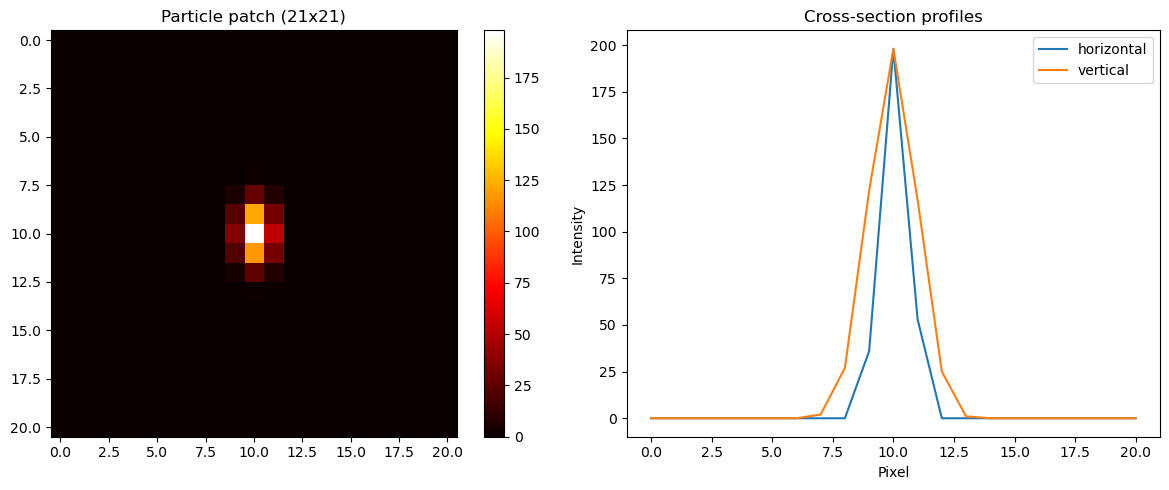

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

sample_img = cv2.imread(r"D:\0.Code\Test\OTF_test\imgFile\cam1\img00002.tif", -1)
print(f"Image shape: {sample_img.shape}, dtype: {sample_img.dtype}")

# 找到最亮的点
max_loc = np.unravel_index(np.argmax(sample_img), sample_img.shape)
print(f"Max location: {max_loc}, value: {sample_img[max_loc]}")

# 显示周围 21x21 像素
r = 10
cy, cx = max_loc
patch = sample_img[max(0,cy-r):cy+r+1, max(0,cx-r):cx+r+1].astype(float)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im = axes[0].imshow(patch, cmap='hot')
plt.colorbar(im, ax=axes[0])
axes[0].set_title("Particle patch (21x21)")

axes[1].plot(patch[r, :], label='horizontal')
axes[1].plot(patch[:, r], label='vertical')
axes[1].legend()
axes[1].set_title("Cross-section profiles")
axes[1].set_xlabel("Pixel")
axes[1].set_ylabel("Intensity")
plt.tight_layout()
plt.show()